# CAN BUS decoding script (To be used in pipeline)

In [ ]:
import pandas as pd
import sys
from typing import List, Dict


In [ ]:
import pandas as pd
import sys

INPUT_FILE = "can_log_dataset.csv"
OUTPUT_FILE = "decoded_telemetry.csv"
CHUNK_SIZE = 50000  # Memory saver

def hex_to_bytes(hex_str):
    if pd.isna(hex_str): return []
    try:
        return [int(x, 16) for x in str(hex_str).strip().split()]
    except ValueError: return []

def get_le_val(data, start, length=2, signed=False):
    if len(data) < start + length: return 0
    val = 0
    for i in range(length):
        val |= (data[start + i] << (8 * i))
    if signed:
        max_val = 1 << (length * 8)
        if val >= max_val // 2: val -= max_val
    return val

first_chunk = True
last_values = None   # Context for forward fill

try:
    reader = pd.read_csv(
        INPUT_FILE,
        encoding="latin1",
        sep=None,
        engine="python",
        skipinitialspace=True,
        chunksize=CHUNK_SIZE
    )
except FileNotFoundError:
    print(f"Error: {INPUT_FILE} not found.")
    sys.exit(1)

for chunk in reader:
    # 1. Clean Headers & Data
    chunk.columns = chunk.columns.str.strip()
    for col in chunk.select_dtypes(include="object"):
        chunk[col] = chunk[col].str.strip()

    # 2. Time Sort (Ensures Chronological Order)
    chunk["Timestamp"] = pd.to_datetime(chunk["Time scale"], errors="coerce")
    chunk = chunk.dropna(subset=["Timestamp"]).sort_values("Timestamp")

    decoded_rows = []

    # 3. Decode Frames
    for _, row in chunk.iterrows():
        try:
            msg_id = int(str(row["Frame Id"]), 16)
            data = hex_to_bytes(row["Data(Hex)"])
            ts = row["Timestamp"]
            entry = {"Time": ts}

            # Safety & Network
            if msg_id == 0x04 and len(data) >= 1:
                entry["Safety_EStop"] = data[0]
            elif msg_id == 0x05 and len(data) >= 1:
                entry["Safety_MotorsLocked"] = data[0]

            # Node Status Request
            elif msg_id == 0x07 and len(data) >= 1:
                entry["Node_status_request"] = data[0] # 0=All, or specific ID

            # Node Heartbeats
            elif msg_id in [0x08, 0x09, 0x0A, 0x0D, 0x0F, 0x10] and len(data) >= 1:
                status_map = {
                    0x08: "Status_ECU", 0x09: "Status_BMS", 0x0A: "Status_TPS",
                    0x0D: "Status_FW",  0x0F: "Status_RLW", 0x10: "Status_RRW"
                }
                entry[status_map[msg_id]] = data[0]

            # --- 0x20: Throttle & Brake (New Logic) ---
            elif msg_id == 0x20 and len(data) >= 5:
                # B0: Throttle %
                entry["Throttle_Pct"] = data[0] * 0.4

                # B2: Brake Pressure (Front/Default)
                entry["Brake_Pressure_Front_kPa"] = data[2] * 4.0

                # B3: Brake Pressure (Rear) - If 255, B2 is default (Rear is unused/unknown)
                if data[3] != 255:
                    entry["Brake_Pressure_Rear_kPa"] = data[3] * 4.0
                else:
                    entry["Brake_Pressure_Rear_kPa"] = 0

                # B4: Brake Pedal %
                entry["Brake_Pedal_Pct"] = data[4] * 0.4

            # --- 0x22: Steering (Existing Logic) ---
            elif msg_id == 0x22 and len(data) >= 2:
                entry["Steering_Angle_Deg"] = get_le_val(data, 0, signed=True) * 0.1 - 180

            # --- 0x24: Battery Stats (New Logic) ---
            elif msg_id == 0x24 and len(data) >= 8: # Assuming 8 bytes for full frame
                # B0-B1: Voltage
                entry["Battery_Voltage_V"] = get_le_val(data, 0, 2) * 0.1

                # B2-B3: Current (Offset -320)
                # User formula: -320 + (B3*256 + B2)*0.1
                raw_curr = get_le_val(data, 2, 2, signed=False)
                entry["Battery_Current_A"] = -320 + (raw_curr * 0.1)

                # B4: SOC
                entry["Battery_SOC_Pct"] = data[4]

                # B5-B6: Resistance
                # User formula: (B6*256+B5)*1000
                raw_res = get_le_val(data, 5, 2, signed=False)
                entry["Battery_Resistance_Ohms"] = raw_res * 0.000001

                # B7: Highest Cell Temp
                # User formula: B8 - 40. Assuming B8 is 8th byte (index 7).
                entry["Battery_Temp_Max_C"] = data[7] - 40.0

            # --- 0x25: Voltage Rails (New Logic) ---
            elif msg_id == 0x25 and len(data) >= 3:
                # B1: 5V Rail
                entry["Voltage_5V_Rail_V"] = data[1] / 36.0
                # B2: 12V Rail
                entry["Voltage_12V_Rail_V"] = data[2] / 10.0

            # --- 0x30: Target Throttles (Existing) ---
            elif msg_id == 0x30 and len(data) >= 4:
                entry["Target_Thr_FL"] = data[0] * 0.4
                entry["Target_Thr_FR"] = data[1] * 0.4
                entry["Target_Thr_RL"] = data[2] * 0.4
                entry["Target_Thr_RR"] = data[3] * 0.4

            # --- 0x34-0x37: Wheel Speed (Existing) ---
            elif msg_id in [0x34, 0x35, 0x36, 0x37] and len(data) >= 2:
                wheel_map = {0x34: "FL", 0x35: "FR", 0x36: "RL", 0x37: "RR"}
                entry[f"Wheel_RPM_{wheel_map[msg_id]}"] = get_le_val(data, 0) / 30.0

            # --- 0x38: Vehicle Speed (New Logic - Replaces IMU) ---
            elif msg_id == 0x38 and len(data) >= 2:
                # User formula: (B1*256 + B0)/256
                raw_speed = get_le_val(data, 0, 2, signed=False)
                entry["Vehicle_Speed_kmh"] = raw_speed / 256.0

            if len(entry) > 1:
                decoded_rows.append(entry)

        except Exception: continue

    # 4. Save Logic (with Forward Fill)
    if decoded_rows:
        out_df = pd.DataFrame(decoded_rows)

        out_df = out_df.sort_values("Time").reset_index(drop=True)


        # Continui  ty: Merge with previous chunk's last row
        if last_values is not None:
            out_df = pd.concat([last_values, out_df], ignore_index=True)

        # Fill missing values (Forward Fill)
        out_df = out_df.ffill()

        out_df = out_df.dropna(how="any")


        # Save last valid row for next chunk's context
        last_values = out_df.tail(1)

        # Remove the carry-over row (to avoid duplicates or edge cases) and save
        out_df = out_df.iloc[:-1]
        out_df["Time"] = out_df["Time"].dt.strftime('%H:%M:%S.%f').str[:-3]

        if not out_df.empty:
            out_df.to_csv(
                OUTPUT_FILE,
                mode="w" if first_chunk else "a",
                header=first_chunk,
                index=False
            )
            first_chunk = False

print(" Complete! Data is decoded, chronologically sorted, and saved.")
print(" File:", OUTPUT_FILE)

/tmp/ipython-input-2171884823.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["Timestamp"] = pd.to_datetime(chunk["Time scale"], errors="coerce")


 Complete! Data is decoded, chronologically sorted, and saved.
 File: decoded_telemetry.csv


# Model Training (Isolation forest)

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

INPUT_FILE = "decoded_telemetry.csv"
MODEL_BUNDLE_FILE = "predictive_maintenance_model.pkl"

#Loading dataset

df = pd.read_csv(INPUT_FILE, parse_dates=["Time"])
df = df.sort_values("Time").reset_index(drop=True)

print("Shape:", df.shape)



# --- Wheel Features ---
rpm_cols = [c for c in df.columns if "Wheel_RPM" in c]

df["Vehicle_Speed_RPM_mean"] = df[rpm_cols].mean(axis=1)
df["Wheel_RPM_std"] = df[rpm_cols].std(axis=1)

# --- Electrical Features ---
df["Battery_Power_W"] = df["Battery_Voltage_V"] * df["Battery_Current_A"]

df["Power_per_Speed"] = df["Battery_Power_W"] / (
    df["Vehicle_Speed_kmh"] + 1e-3
)

# --- Torque Command Consistency ---
thr_cols = [
    "Target_Thr_FL",
    "Target_Thr_FR",
    "Target_Thr_RL",
    "Target_Thr_RR"
]

df["Target_Thr_mean"] = df[thr_cols].mean(axis=1)

df["Torque_Command_Error"] = (
    df["Target_Thr_mean"] - df["Throttle_Pct"]
).abs()

# --- Brake Balance ---
df["Brake_Pressure_Diff"] = (
    df["Brake_Pressure_Front_kPa"] -
    df["Brake_Pressure_Rear_kPa"]
).abs()

# --- Battery Thermal Stress ---
df["Temp_Stress_Index"] = (
    df["Battery_Temp_Max_C"] *
    df["Battery_Current_A"].abs()
)


IF_FEATURES = [
    # Speed & motion
    "Vehicle_Speed_kmh",
    "Vehicle_Speed_RPM_mean",
    "Wheel_RPM_std",

    # Electrical
    "Battery_Voltage_V",
    "Battery_Current_A",
    "Battery_Power_W",
    "Power_per_Speed",

    # Battery health
    "Battery_SOC_Pct",
    "Battery_Resistance_Ohms",
    "Battery_Temp_Max_C",
    "Temp_Stress_Index",

    # Driver command mismatch
    "Throttle_Pct",
    "Torque_Command_Error",

    # Brake system
    "Brake_Pedal_Pct",
    "Brake_Pressure_Front_kPa",
    "Brake_Pressure_Rear_kPa",
    "Brake_Pressure_Diff"
]

IF_FEATURES = [c for c in IF_FEATURES if c in df.columns]

X = df[IF_FEATURES].copy()

print("\nIsolation Forest features:")
print(IF_FEATURES)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


model = IsolationForest(
    n_estimators=400,          # Slightly higher for better stability
    contamination=0.01,       # 1% anomaly assumption
    max_samples="auto",
    random_state=42,
    n_jobs=-1
)

model.fit(X_scaled)


#Anomaly score
df["if_score"] = model.decision_function(X_scaled)
df["if_anomaly"] = (model.predict(X_scaled) == -1).astype(int)

#Severity index
score_min = df["if_score"].min()
score_max = df["if_score"].max()

#Normalize score into severity
df["if_severity"] = 1 - (
    (df["if_score"] - score_min) /
    (score_max - score_min + 1e-6)
)

#Count total  number of anomalies detected
n_anomaly = df["if_anomaly"].sum()
pct = n_anomaly / len(df) * 100

print("\n===== Isolation Forest Summary =====")
print("Total samples:", len(df))
print("Detected anomalies:", n_anomaly)
print("Anomaly %:", round(pct, 2))




df.to_csv(OUTPUT_FILE, index=False)
print("\n✅ Saved CSV:", OUTPUT_FILE)


model_bundle = {
    "model": model,
    "scaler": scaler,
    "features": IF_FEATURES
}

joblib.dump(model_bundle, MODEL_BUNDLE_FILE)

print("✅ Saved bundled model:", MODEL_BUNDLE_FILE)


/tmp/ipython-input-1484108963.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(INPUT_FILE, parse_dates=["Time"])


Shape: (1939, 28)

Isolation Forest features:
['Vehicle_Speed_kmh', 'Vehicle_Speed_RPM_mean', 'Wheel_RPM_std', 'Battery_Voltage_V', 'Battery_Current_A', 'Battery_Power_W', 'Power_per_Speed', 'Battery_SOC_Pct', 'Battery_Resistance_Ohms', 'Battery_Temp_Max_C', 'Temp_Stress_Index', 'Throttle_Pct', 'Torque_Command_Error', 'Brake_Pedal_Pct', 'Brake_Pressure_Front_kPa', 'Brake_Pressure_Rear_kPa', 'Brake_Pressure_Diff']

===== Isolation Forest Summary =====
Total samples: 1939
Detected anomalies: 2
Anomaly %: 0.1

✅ Saved CSV: decoded_telemetry.csv
✅ Saved bundled model: predictive_maintenance_model.pkl


# Saving Isolation Forest Model suitable for ESP32 Integration

In [ ]:
def export_isolation_forest(model, feature_names, filename="iforest_export.h"):
    with open(filename, "w") as f:
        f.write("#pragma once\n\n") #Prevent multiple inclusions of header file in C/C++
        f.write(f"#define NUM_TREES {len(model.estimators_)}\n") #Define total number of trees
        f.write(f"#define NUM_FEATURES {len(feature_names)}\n\n") #Define total number of input features expected by model


        for i, estimator in enumerate(model.estimators_): #Loop through each decision tree in Isolation Forest
            tree = estimator.tree_ #Access tree structure

            #Export feature index array
            f.write(f"// Tree {i}\n")
            f.write(f"const int tree_{i}_feature[] = {{")
            f.write(",".join(map(str, tree.feature)))
            f.write("};\n")

            #Export threshold array
            f.write(f"const float tree_{i}_threshold[] = {{")
            f.write(",".join(map(str, tree.threshold)))
            f.write("};\n")

            #Export left child index array
            f.write(f"const int tree_{i}_left[] = {{")
            f.write(",".join(map(str, tree.children_left)))
            f.write("};\n")

            #Export right child index array
            f.write(f"const int tree_{i}_right[] = {{")
            f.write(",".join(map(str, tree.children_right)))
            f.write("};\n\n")

    print(" Exported Isolation Forest to iforest_export.h")

export_isolation_forest(model, IF_FEATURES)


✅ Exported Isolation Forest to iforest_export.h


# LSTM Autoencoder

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# Load & Sort
# =========================
INPUT_FILE = "decoded_telemetry.csv"
OUTPUT_FILE = "telemetry_with_lstm_ae.csv"

df = pd.read_csv(INPUT_FILE, parse_dates=["Time"])
df = df.sort_values("Time").reset_index(drop=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# =========================
# Base Feature Selection (NEW SCHEMA)
# =========================
BASE_FEATURES = [
    # Wheel dynamics
    "Wheel_RPM_FL", "Wheel_RPM_FR",
    "Wheel_RPM_RL", "Wheel_RPM_RR",

    # Driver / chassis
    "Throttle_Pct",
    "Brake_Pedal_Pct",
    "Brake_Pressure_Front_kPa",
    "Brake_Pressure_Rear_kPa",

    # Battery electrical
    "Battery_Voltage_V",
    "Battery_Current_A",
    "Battery_SOC_Pct",
    "Battery_Resistance_Ohms",
    "Battery_Temp_Max_C",

    # Torque commands
    "Target_Thr_FL", "Target_Thr_FR",
    "Target_Thr_RL", "Target_Thr_RR",

    # Vehicle speed
    "Vehicle_Speed_kmh"
]

TRAIN_FEATURES = [c for c in BASE_FEATURES if c in df.columns]

# =========================
# Feature Engineering (SAFE & MEANINGFUL)
# =========================

# Wheel RPM imbalance
rpm_cols = [c for c in df.columns if "Wheel_RPM_" in c]
if len(rpm_cols) == 4:
    df["Wheel_RPM_std"] = df[rpm_cols].std(axis=1)
    TRAIN_FEATURES.append("Wheel_RPM_std")

# Battery power
if {"Battery_Voltage_V", "Battery_Current_A"}.issubset(df.columns):
    df["Battery_Power_W"] = df["Battery_Voltage_V"] * df["Battery_Current_A"]
    TRAIN_FEATURES.append("Battery_Power_W")

# Torque command mean
thr_cols = [c for c in df.columns if c.startswith("Target_Thr_")]
if len(thr_cols) == 4:
    df["Target_Thr_mean"] = df[thr_cols].mean(axis=1)
    TRAIN_FEATURES.append("Target_Thr_mean")

# Temporal derivatives (LSTM-friendly)
if "Vehicle_Speed_kmh" in df.columns:
    df["dSpeed"] = df["Vehicle_Speed_kmh"].diff().fillna(0)
    TRAIN_FEATURES.append("dSpeed")

if "Battery_Temp_Max_C" in df.columns:
    df["dBattery_Temp"] = df["Battery_Temp_Max_C"].diff().fillna(0)
    TRAIN_FEATURES.append("dBattery_Temp")

print("\nFinal training features:")
print(TRAIN_FEATURES)

# =========================
# Prepare Data
# =========================
X = df[TRAIN_FEATURES].copy()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# Create Sliding Windows
# =========================
SEQUENCE_LENGTH = 20  # ~1–2s context

def create_sequences(data, seq_len):
    return np.array([
        data[i:i + seq_len]
        for i in range(len(data) - seq_len)
    ])

X_seq = create_sequences(X_scaled, SEQUENCE_LENGTH)
print("Sequence shape:", X_seq.shape)

# =========================
# Train / Validation Split
# =========================
split = int(0.8 * len(X_seq))
X_train = X_seq[:split]
X_val = X_seq[split:]

print("Train:", X_train.shape)
print("Val:", X_val.shape)

# =========================
# LSTM Autoencoder
# =========================
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

inputs = Input(shape=(timesteps, n_features))

encoded = LSTM(64, return_sequences=True)(inputs)
encoded = LSTM(32, return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, return_sequences=True)(decoded)
decoded = LSTM(64, return_sequences=True)(decoded)

outputs = TimeDistributed(Dense(n_features))(decoded)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()

# =========================
# Train
# =========================
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Reconstruction Error
# =========================
X_pred = model.predict(X_seq, verbose=0)

recon_error = np.mean(
    np.square(X_seq - X_pred),
    axis=(1, 2)
)

df["lstm_recon_error"] = np.nan
df.loc[SEQUENCE_LENGTH:, "lstm_recon_error"] = recon_error

# =========================
# Anomaly Detection
# =========================
threshold = np.percentile(recon_error, 95)

df["lstm_anomaly"] = (
    df["lstm_recon_error"] > threshold
).astype(int)

# =========================
# Metrics
# =========================
print("\n===== LSTM AE Summary =====")
print("Samples:", len(df))
print("Anomalies:", df["lstm_anomaly"].sum())
print("Anomaly %:", round(df["lstm_anomaly"].mean() * 100, 2))
print("Threshold:", threshold)

# =========================
# Save
# =========================
df.to_csv(OUTPUT_FILE, index=False)
print("\n✅ Saved:", OUTPUT_FILE)


/tmp/ipython-input-2049321908.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(INPUT_FILE, parse_dates=["Time"])


Shape: (1939, 28)
Columns: ['Time', 'Wheel_RPM_RL', 'Wheel_RPM_FR', 'Throttle_Pct', 'Brake_Pressure_Front_kPa', 'Brake_Pressure_Rear_kPa', 'Brake_Pedal_Pct', 'Wheel_RPM_RR', 'Battery_Voltage_V', 'Battery_Current_A', 'Battery_SOC_Pct', 'Battery_Resistance_Ohms', 'Battery_Temp_Max_C', 'Target_Thr_FL', 'Target_Thr_FR', 'Target_Thr_RL', 'Target_Thr_RR', 'Wheel_RPM_FL', 'Vehicle_Speed_kmh', 'Status_ECU', 'Safety_EStop', 'Status_FW', 'Safety_MotorsLocked', 'Node_status_request', 'Status_RRW', 'Status_BMS', 'Status_TPS', 'Status_RLW']

Final training features:
['Wheel_RPM_FL', 'Wheel_RPM_FR', 'Wheel_RPM_RL', 'Wheel_RPM_RR', 'Throttle_Pct', 'Brake_Pedal_Pct', 'Brake_Pressure_Front_kPa', 'Brake_Pressure_Rear_kPa', 'Battery_Voltage_V', 'Battery_Current_A', 'Battery_SOC_Pct', 'Battery_Resistance_Ohms', 'Battery_Temp_Max_C', 'Target_Thr_FL', 'Target_Thr_FR', 'Target_Thr_RL', 'Target_Thr_RR', 'Vehicle_Speed_kmh', 'Wheel_RPM_std', 'Battery_Power_W', 'Target_Thr_mean', 'dSpeed', 'dBattery_Temp']
Sequ

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 23)         │         1,495 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,591 (271.84 KB)

 Trainable params: 69,591 (271.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.

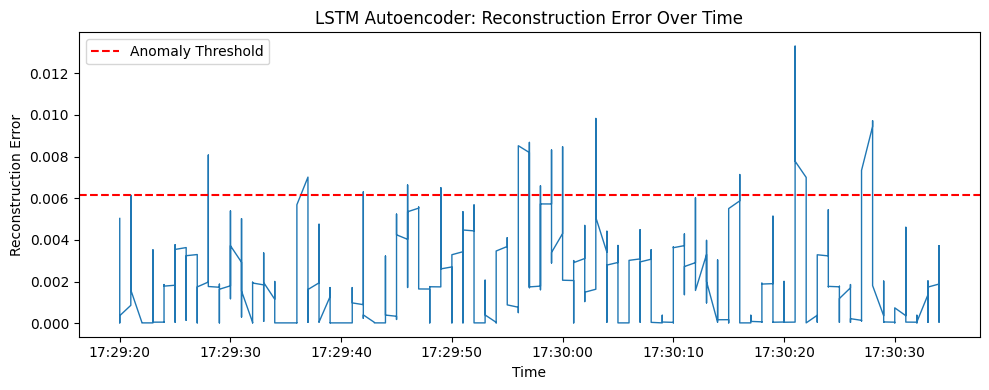

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.plot(
    df["Time"],
    df["lstm_recon_error"],
    linewidth=1
)

plt.axhline(
    y=df["lstm_recon_error"].quantile(0.95),
    color="red",
    linestyle="--",
    label="Anomaly Threshold"
)

plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.title("LSTM Autoencoder: Reconstruction Error Over Time")
plt.legend()
plt.tight_layout()
plt.show()


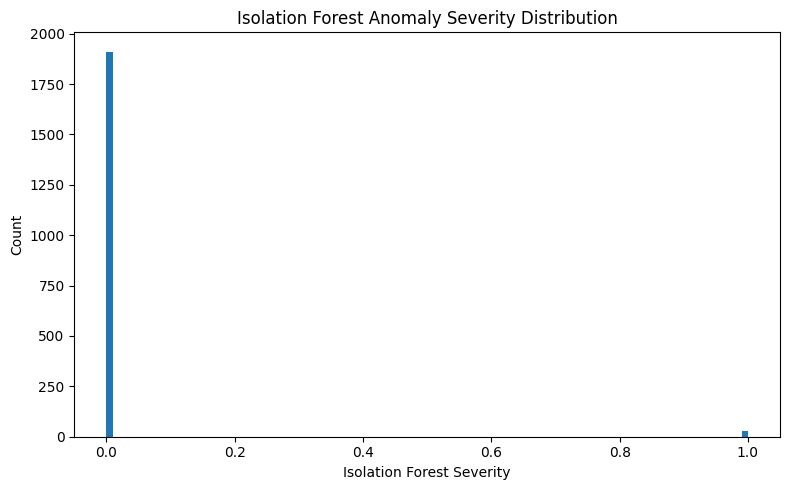

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["if_severity"], bins=100)
plt.xlabel("Isolation Forest Severity")
plt.ylabel("Count")
plt.title("Isolation Forest Anomaly Severity Distribution")
plt.tight_layout()
plt.show()


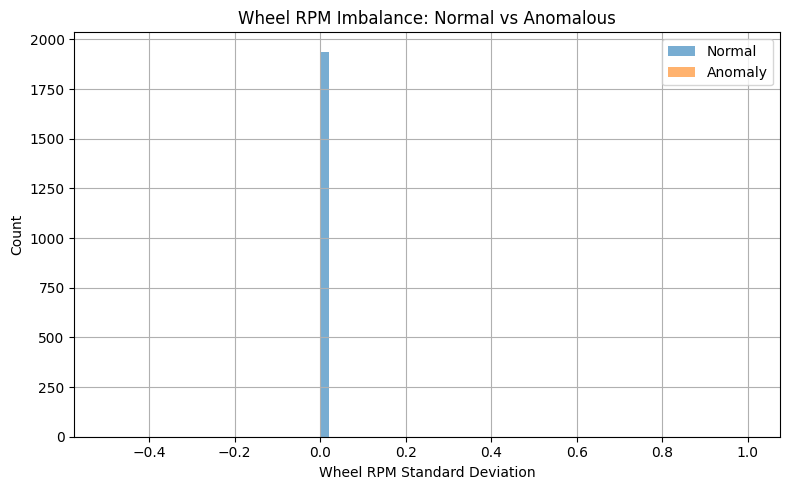

In [ ]:
plt.figure(figsize=(8,5))

df[df["if_anomaly"] == 0]["Wheel_RPM_std"].hist(
    bins=50, alpha=0.6, label="Normal"
)
df[df["if_anomaly"] == 1]["Wheel_RPM_std"].hist(
    bins=50, alpha=0.6, label="Anomaly"
)

plt.xlabel("Wheel RPM Standard Deviation")
plt.ylabel("Count")
plt.title("Wheel RPM Imbalance: Normal vs Anomalous")
plt.legend()
plt.tight_layout()
plt.show()


# K-means clustering

In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# =========================
# Load & Sort
# =========================
INPUT_FILE = "decoded_telemetry.csv"
OUTPUT_FILE = "telemetry_with_kmeans.csv"

df = pd.read_csv(INPUT_FILE, parse_dates=["Time"])
df = df.sort_values("Time").reset_index(drop=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# =========================
# Base Feature Selection (NEW SCHEMA)
# =========================
BASE_FEATURES = [
    # Wheel dynamics
    "Wheel_RPM_FL", "Wheel_RPM_FR",
    "Wheel_RPM_RL", "Wheel_RPM_RR",

    # Driver / braking
    "Throttle_Pct",
    "Brake_Pedal_Pct",
    "Brake_Pressure_Front_kPa",
    "Brake_Pressure_Rear_kPa",

    # Battery
    "Battery_Voltage_V",
    "Battery_Current_A",
    "Battery_SOC_Pct",
    "Battery_Resistance_Ohms",
    "Battery_Temp_Max_C",

    # Torque commands
    "Target_Thr_FL", "Target_Thr_FR",
    "Target_Thr_RL", "Target_Thr_RR",

    # Vehicle speed
    "Vehicle_Speed_kmh"
]

FEATURES = [c for c in BASE_FEATURES if c in df.columns]

# =========================
# Feature Engineering (K-MEANS FRIENDLY)
# =========================

# Wheel imbalance
rpm_cols = [c for c in df.columns if "Wheel_RPM_" in c]
if len(rpm_cols) == 4:
    df["Wheel_RPM_std"] = df[rpm_cols].std(axis=1)
    FEATURES.append("Wheel_RPM_std")

# Battery power
if {"Battery_Voltage_V", "Battery_Current_A"}.issubset(df.columns):
    df["Battery_Power_W"] = df["Battery_Voltage_V"] * df["Battery_Current_A"]
    FEATURES.append("Battery_Power_W")

# Torque command mean
thr_cols = [c for c in df.columns if c.startswith("Target_Thr_")]
if len(thr_cols) == 4:
    df["Target_Thr_mean"] = df[thr_cols].mean(axis=1)
    FEATURES.append("Target_Thr_mean")

print("\nK-Means features:")
print(FEATURES)

# =========================
# Prepare Data
# =========================
X = df[FEATURES].copy()

# Remove rows with NaNs (K-Means cannot handle NaNs)
X = X.dropna()
df_km = df.loc[X.index].copy()

print("Training samples:", len(X))

# =========================
# Scaling (MANDATORY)
# =========================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# PCA (Noise reduction + geometry)
# =========================
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA components retained:", X_pca.shape[1])

# =========================
# Optimal K Selection
# =========================
K_RANGE = range(2, 8)
sil_scores = {}
inertias = {}

for k in K_RANGE:
    km = KMeans(
        n_clusters=k,
        n_init=20,
        max_iter=500,
        random_state=42
    )
    labels = km.fit_predict(X_pca)
    sil_scores[k] = silhouette_score(X_pca, labels)
    inertias[k] = km.inertia_

best_k = max(sil_scores, key=sil_scores.get)

print("\n===== K Selection =====")
print("Silhouette scores:", sil_scores)
print("Inertias:", inertias)
print("Best K:", best_k)

# =========================
# Train Final K-Means
# =========================
kmeans = KMeans(
    n_clusters=best_k,
    n_init=30,
    max_iter=1000,
    random_state=42
)

df_km["cluster"] = kmeans.fit_predict(X_pca)

# =========================
# Distance-to-Centroid (Anomaly Proxy)
# =========================
centroids = kmeans.cluster_centers_

distances = np.linalg.norm(
    X_pca - centroids[df_km["cluster"]],
    axis=1
)

df_km["kmeans_distance"] = distances

# =========================
# Anomaly Flag (Top 5%)
# =========================
threshold = np.percentile(distances, 95)

df_km["kmeans_anomaly"] = (
    df_km["kmeans_distance"] > threshold
).astype(int)

# =========================
# Metrics
# =========================
print("\n===== K-Means Summary =====")
print("Samples:", len(df_km))
print("Clusters:", best_k)
print("Silhouette score:", round(sil_scores[best_k], 3))
print("Anomalies detected:", df_km["kmeans_anomaly"].sum())

# =========================
# Cluster Profiles (Operating Modes)
# =========================
print("\n===== Cluster Profiles =====")
print(
    df_km.groupby("cluster")[FEATURES]
    .mean()
    .round(2)
)

# =========================
# Merge Back & Save
# =========================
df_out = df.copy()
df_out.loc[df_km.index, "cluster"] = df_km["cluster"]
df_out.loc[df_km.index, "kmeans_distance"] = df_km["kmeans_distance"]
df_out.loc[df_km.index, "kmeans_anomaly"] = df_km["kmeans_anomaly"]

df_out.to_csv(OUTPUT_FILE, index=False)
print("\n✅ Saved:", OUTPUT_FILE)


/tmp/ipython-input-3002119573.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(INPUT_FILE, parse_dates=["Time"])


Shape: (1939, 28)
Columns: ['Time', 'Wheel_RPM_RL', 'Wheel_RPM_FR', 'Throttle_Pct', 'Brake_Pressure_Front_kPa', 'Brake_Pressure_Rear_kPa', 'Brake_Pedal_Pct', 'Wheel_RPM_RR', 'Battery_Voltage_V', 'Battery_Current_A', 'Battery_SOC_Pct', 'Battery_Resistance_Ohms', 'Battery_Temp_Max_C', 'Target_Thr_FL', 'Target_Thr_FR', 'Target_Thr_RL', 'Target_Thr_RR', 'Wheel_RPM_FL', 'Vehicle_Speed_kmh', 'Status_ECU', 'Safety_EStop', 'Status_FW', 'Safety_MotorsLocked', 'Node_status_request', 'Status_RRW', 'Status_BMS', 'Status_TPS', 'Status_RLW']

K-Means features:
['Wheel_RPM_FL', 'Wheel_RPM_FR', 'Wheel_RPM_RL', 'Wheel_RPM_RR', 'Throttle_Pct', 'Brake_Pedal_Pct', 'Brake_Pressure_Front_kPa', 'Brake_Pressure_Rear_kPa', 'Battery_Voltage_V', 'Battery_Current_A', 'Battery_SOC_Pct', 'Battery_Resistance_Ohms', 'Battery_Temp_Max_C', 'Target_Thr_FL', 'Target_Thr_FR', 'Target_Thr_RL', 'Target_Thr_RR', 'Vehicle_Speed_kmh', 'Wheel_RPM_std', 'Battery_Power_W', 'Target_Thr_mean']
Training samples: 1939
PCA components 

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)



===== K Selection =====
Silhouette scores: {2: np.float64(0.9705075801422833), 3: np.float64(0.9993720164408123), 4: np.float64(0.999866794821965), 5: np.float64(0.9999999963922418), 6: np.float64(0.9999999963922418), 7: np.float64(0.9999999963922418)}
Inertias: {2: 29.507315578353673, 3: 0.029836813104059494, 4: 0.006127402504565681, 5: 1.5258703504828907e-26, 6: 1.5258703504828907e-26, 7: 1.5123980468173143e-26}
Best K: 5

===== K-Means Summary =====
Samples: 1939
Clusters: 5
Silhouette score: 1.0
Anomalies detected: 0

===== Cluster Profiles =====
         Wheel_RPM_FL  Wheel_RPM_FR  Wheel_RPM_RL  Wheel_RPM_RR  Throttle_Pct  \
cluster                                                                         
0                 0.0           0.0           0.0           0.0           0.0   
1                 0.0           0.0           0.0           0.0           0.0   
2                 0.0           0.0           0.0           0.0           0.0   
3                 0.0           0.0  

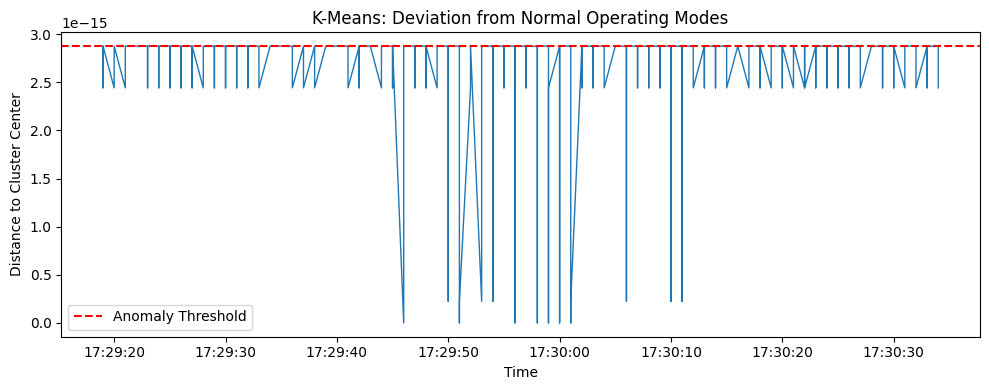

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(
    df_km["Time"],
    df_km["kmeans_distance"],
    linewidth=1
)

plt.axhline(
    df_km["kmeans_distance"].quantile(0.95),
    color="red",
    linestyle="--",
    label="Anomaly Threshold"
)

plt.xlabel("Time")
plt.ylabel("Distance to Cluster Center")
plt.title("K-Means: Deviation from Normal Operating Modes")
plt.legend()
plt.tight_layout()
plt.show()
